## Respiratory Illness Classification

In [ ]:
#Import necessary packages
import pandas as pd
import numpy as np
import math
import librosa as lb 
import soundfile as sf 
import os
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from sklearn import preprocessing
import wave
import h5py
from scipy.signal import butter, lfilter
from scipy.signal import freqz

In [ ]:
#load patient diagnosis.csv
pat_diag = pd.read_csv("patient_diagnosis.csv", names=['pId', 'diagnosis'])

In [3]:
#Preview dataframe
pat_diag

,pId,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI
...,...,...
121,222,COPD
122,223,COPD
123,224,Healthy
124,225,Healthy


In [4]:
#get all unique text files containing audio information
files = [s.split('.')[0] for s in os.listdir(path = "audio_and_txt_files/") if '.txt' in s]

In [5]:
len(files)

920

In [6]:
files[0:10]

['101_1b1_Al_sc_Meditron',
 '101_1b1_Pr_sc_Meditron',
 '102_1b1_Ar_sc_Meditron',
 '103_2b2_Ar_mc_LittC2SE',
 '104_1b1_Al_sc_Litt3200',
 '104_1b1_Ar_sc_Litt3200',
 '104_1b1_Ll_sc_Litt3200',
 '104_1b1_Lr_sc_Litt3200',
 '104_1b1_Pl_sc_Litt3200',
 '104_1b1_Pr_sc_Litt3200']

In [7]:
#Create a new Dataframe for string the file info
file_data = pd.DataFrame(columns=['fname','start', 'end', 'crackles', 'wheezes'])

In [8]:
#read each file and append data to existing data frame
for f in files:
    df = pd.read_csv("audio_and_txt_files/" + f + '.txt', sep='\t', names=['start', 'end', 'crackles', 'wheezes'])
    df['fname'] = f
    file_data = file_data.append(df, ignore_index=True)


In [9]:
file_data

,fname,start,end,crackles,wheezes
0,101_1b1_Al_sc_Meditron,0.036,0.579,0,0
1,101_1b1_Al_sc_Meditron,0.579,2.450,0,0
2,101_1b1_Al_sc_Meditron,2.450,3.893,0,0
3,101_1b1_Al_sc_Meditron,3.893,5.793,0,0
4,101_1b1_Al_sc_Meditron,5.793,7.521,0,0
...,...,...,...,...,...
6893,226_1b1_Pl_sc_LittC2SE,11.721,13.693,1,0
6894,226_1b1_Pl_sc_LittC2SE,13.693,15.536,0,0
6895,226_1b1_Pl_sc_LittC2SE,15.536,17.493,0,0
6896,226_1b1_Pl_sc_LittC2SE,17.493,19.436,1,0


In [10]:
#Encode crackles and wheezes in single column
crack_wheez = []
for idx, row in file_data.iterrows():
    if row['crackles'] == 0 and row['wheezes'] == 0:
        crack_wheez.append(0)
    elif row['crackles'] == 1 and row['wheezes'] == 0:
        crack_wheez.append(1)
    elif row['crackles'] == 0 and row['wheezes'] == 1:
        crack_wheez.append(2)
    else:
        crack_wheez.append(3)

In [11]:
file_data['crack_wheez'] = crack_wheez 

In [12]:
file_data[file_data.crack_wheez == 1]

,fname,start,end,crackles,wheezes,crack_wheez
66,104_1b1_Ll_sc_Litt3200,8.8287,10.396,1,0,1
105,106_2b1_Pl_mc_LittC2SE,0.0360,2.164,1,0,1
106,106_2b1_Pl_mc_LittC2SE,2.1640,4.621,1,0,1
108,106_2b1_Pl_mc_LittC2SE,7.1790,9.636,1,0,1
109,106_2b1_Pl_mc_LittC2SE,9.6360,12.007,1,0,1
...,...,...,...,...,...,...
6889,226_1b1_Pl_sc_LittC2SE,3.5500,5.750,1,0,1
6890,226_1b1_Pl_sc_LittC2SE,5.7500,7.879,1,0,1
6892,226_1b1_Pl_sc_LittC2SE,9.8360,11.721,1,0,1
6893,226_1b1_Pl_sc_LittC2SE,11.7210,13.693,1,0,1


In [13]:
file_data.drop(columns=['crackles', 'wheezes'],inplace= True)

## Distribution of Classes and their stats

In [14]:
print('Normal  : ', len(file_data[file_data.crack_wheez ==0]))
print('Crackles: ', len(file_data[file_data.crack_wheez ==1]))
print('Wheezes : ', len(file_data[file_data.crack_wheez ==2]))
print('Both    : ', len(file_data[file_data.crack_wheez ==3]))

Normal  :  3642
Crackles:  1864
Wheezes :  886
Both    :  506


Longest cycle :  16.163
Shortest cycle:  0.20000000000000284
Average length:  2.7005090852420994


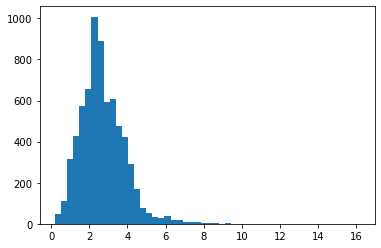

In [15]:
#Histogram of duration statistics
dur = file_data['end'].sub(file_data['start'], axis = 0) 
plt.hist(dur, bins = 50)
print('Longest cycle : ', max(dur))
print('Shortest cycle: ', min(dur))
print('Average length: ', np.mean(dur))
plt.show()

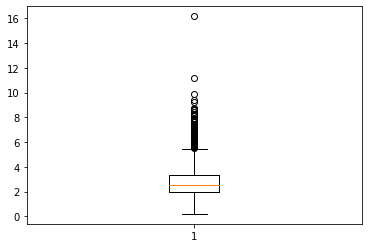

In [16]:
box = plt.boxplot(file_data['end'].sub(file_data['start'], axis = 0))

In [17]:
#Relative maximum
rel_max = [item.get_ydata()[1] for item in box['whiskers']][1]
rel_max = np.floor(rel_max)
rel_max

5.0

In [18]:
#Check the audio file's properties such as number of channels, sample width in bytes, framerate, etc.,
frate = []
device = []
chloc = []
for fn in files:
    file_name = 'audio_and_txt_files/' + fn +'.wav'
    f_features = fn.split('_')
    device.append(f_features[4])
    chloc.append(f_features[2])
    with wave.open(file_name) as f:
        frate.append(f.getframerate())
        

In [19]:
data_df =  pd.DataFrame(columns=['fname', 'chloc', 'device', 'frate'])

In [20]:
data_df['fname'] = files
data_df['chloc'] = chloc
data_df['device'] = device
data_df['frate'] = frate

In [21]:
print('Frates : Recordings')
print(data_df.frate.value_counts())

Frates : Recordings
44100    824
4000      90
10000      6
Name: frate, dtype: int64


In [22]:
print('Device : Recordings')
print(data_df.device.value_counts())

Device : Recordings
AKGC417L    646
Meditron    127
LittC2SE     87
Litt3200     60
Name: device, dtype: int64


In [23]:
file_data[file_data['fname'] == '106_2b1_Pl_mc_LittC2SE']

,fname,start,end,crack_wheez
105,106_2b1_Pl_mc_LittC2SE,0.036,2.164,1
106,106_2b1_Pl_mc_LittC2SE,2.164,4.621,1
107,106_2b1_Pl_mc_LittC2SE,4.621,7.179,0
108,106_2b1_Pl_mc_LittC2SE,7.179,9.636,1
109,106_2b1_Pl_mc_LittC2SE,9.636,12.007,1
110,106_2b1_Pl_mc_LittC2SE,12.007,14.407,1
111,106_2b1_Pl_mc_LittC2SE,14.407,16.793,1
112,106_2b1_Pl_mc_LittC2SE,16.793,19.207,1
113,106_2b1_Pl_mc_LittC2SE,19.207,19.964,1


## Visualize the data

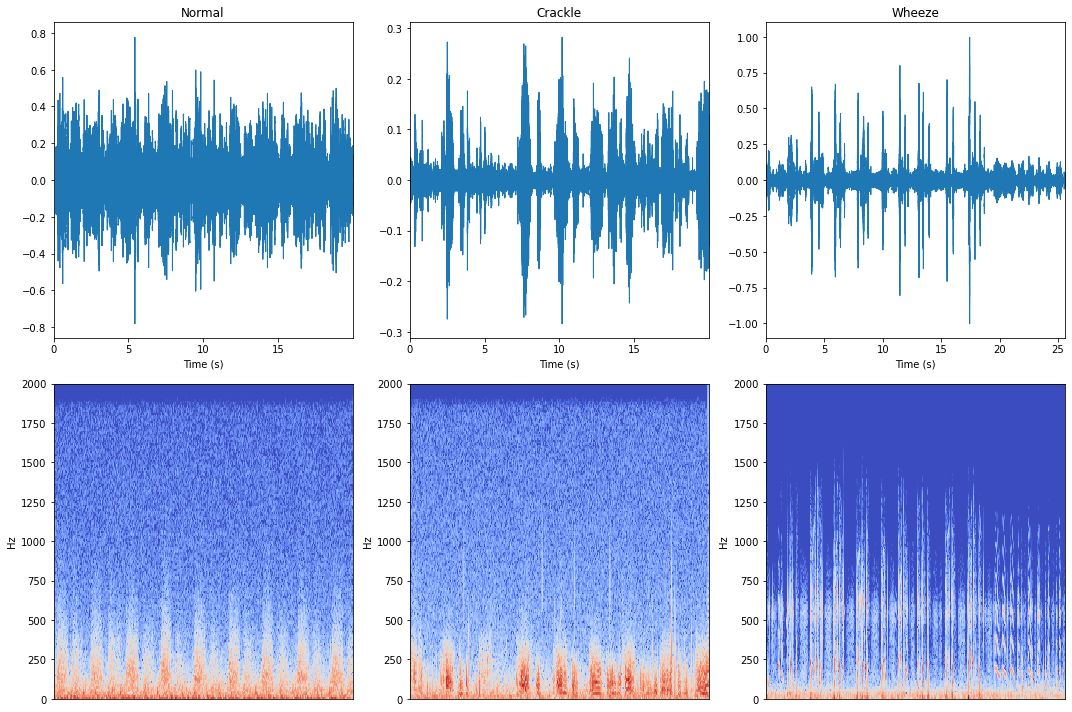

In [24]:
fig, ax = plt.subplots(2, 3,figsize=(15,10))

norm, sr = lb.load('audio_and_txt_files/207_3b2_Pl_mc_AKGC417L.wav',sr = 4000)
lb.display.waveplot(norm, sr=sr, x_axis='s', ax=ax[0, 0])
ax[0, 0].title.set_text('Normal') 

X = librosa.stft(norm, n_fft=400)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=sr, y_axis='hz',ax=ax[1,0])

crc, sr = lb.load('audio_and_txt_files/106_2b1_Pl_mc_LittC2SE.wav', sr = 4000)
lb.display.waveplot(crc, sr=sr, x_axis='s', ax= ax[0,1])
ax[0, 1].title.set_text('Crackle') 

Y = librosa.stft(crc, n_fft=400)
Ydb = librosa.amplitude_to_db(abs(Y))
librosa.display.specshow(Ydb, sr=sr, y_axis='hz',ax=ax[1,1])

whz, sr = lb.load('audio_and_txt_files/104_1b1_Ar_sc_Litt3200.wav', sr =  4000)
lb.display.waveplot(whz, sr=sr, x_axis='s', ax= ax[0,2])
ax[0, 2].title.set_text('Wheeze') 

Z = librosa.stft(whz, n_fft=400)
Zdb = librosa.amplitude_to_db(abs(Z))
librosa.display.specshow(Zdb, sr=sr, y_axis='hz',ax=ax[1,2])

plt.tight_layout()
plt.show()

### Butterworth Bandpass filter

#### To maintain consistency, the audio recordings were downsampled to 4000 Hz, therefore the frequency range of the signal goes from 0 to 2000 Hz. Applied a 12th order butterworth bandpass filter with cutoff frequencies of 100 Hz to 1800 Hz. 

In [25]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

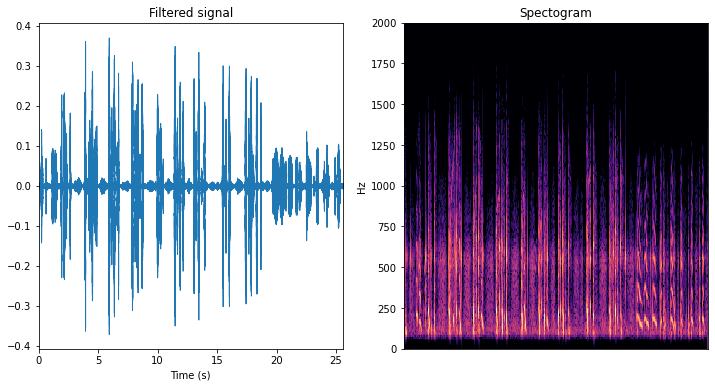

In [26]:
# Sample rate and desired cutoff frequencies (in Hz).
fs = 4000.0
lowcut = 100.0
highcut = 1800.0

fig, ax = plt.subplots(1, 2,figsize=(12,6))

ast, sr = lb.load('audio_and_txt_files/104_1b1_Ar_sc_Litt3200.wav', sr = 4000)
bb = butter_bandpass_filter(ast, lowcut, highcut, fs, order=12)
Ybb = librosa.stft(bb, n_fft=400)
Ydb = librosa.amplitude_to_db(abs(Ybb))

lb.display.waveplot(bb, sr=4000, x_axis='s', ax=ax[0])
librosa.display.specshow(Ydb, sr=4000, y_axis='hz', ax=ax[1])

ax[0].title.set_text('Filtered signal')
ax[1].title.set_text('Spectogram') 

plt.show()

### Load audio, downsample, slice audio into breath cycles, filter out noise

In [27]:
def slice_data(start, end, raw_data,  sample_rate):
    max_ind = len(raw_data) 
    start_ind = min(int(start * sample_rate), max_ind)
    end_ind = min(int(end * sample_rate), max_ind)
    return raw_data[start_ind: end_ind]

In [28]:
i = 0
fname_cycles = []
for idx, row in file_data.iterrows():
    filename = row['fname']
    start = row['start']
    end = row['end']
    
    aud_loc = 'audio_and_txt_files/' + filename + '.wav'
    
    if idx != 0:
        if file_data.iloc[idx-1]['fname'] == filename:
            i=i+1
        else:
            i=0
    n_filename = filename + '_' + str(i) + '.wav'
    path = 'Breath_cycles/' +  n_filename
    fname_cycles.append(n_filename)
    data, samplingrate = lb.load(aud_loc, sr = 4000)
    sliced_data = slice_data(start=start, end=end, raw_data=data, sample_rate=samplingrate)
    filtered_data = butter_bandpass_filter(sliced_data, lowcut, highcut, fs, order=12)
    sf.write(file=path, data=filtered_data, samplerate=samplingrate)

In [29]:
fname_cycles[0:10]

['101_1b1_Al_sc_Meditron_0.wav',
 '101_1b1_Al_sc_Meditron_1.wav',
 '101_1b1_Al_sc_Meditron_2.wav',
 '101_1b1_Al_sc_Meditron_3.wav',
 '101_1b1_Al_sc_Meditron_4.wav',
 '101_1b1_Al_sc_Meditron_5.wav',
 '101_1b1_Al_sc_Meditron_6.wav',
 '101_1b1_Al_sc_Meditron_7.wav',
 '101_1b1_Al_sc_Meditron_8.wav',
 '101_1b1_Al_sc_Meditron_9.wav']

In [30]:
#save for later use
file_data['fname_cycle'] =fname_cycles

In [31]:
file_data

,fname,start,end,crack_wheez,fname_cycle
0,101_1b1_Al_sc_Meditron,0.036,0.579,0,101_1b1_Al_sc_Meditron_0.wav
1,101_1b1_Al_sc_Meditron,0.579,2.450,0,101_1b1_Al_sc_Meditron_1.wav
2,101_1b1_Al_sc_Meditron,2.450,3.893,0,101_1b1_Al_sc_Meditron_2.wav
3,101_1b1_Al_sc_Meditron,3.893,5.793,0,101_1b1_Al_sc_Meditron_3.wav
4,101_1b1_Al_sc_Meditron,5.793,7.521,0,101_1b1_Al_sc_Meditron_4.wav
...,...,...,...,...,...
6893,226_1b1_Pl_sc_LittC2SE,11.721,13.693,1,226_1b1_Pl_sc_LittC2SE_6.wav
6894,226_1b1_Pl_sc_LittC2SE,13.693,15.536,0,226_1b1_Pl_sc_LittC2SE_7.wav
6895,226_1b1_Pl_sc_LittC2SE,15.536,17.493,0,226_1b1_Pl_sc_LittC2SE_8.wav
6896,226_1b1_Pl_sc_LittC2SE,17.493,19.436,1,226_1b1_Pl_sc_LittC2SE_9.wav


In [32]:
file_data.to_csv('file_data.csv', index=False)